# Initialize simulator

In [1]:
import numpy as np
import itertools
from backend.simulation_tools import Simulator
from tasks import flip_flop
import matplotlib.pyplot as plt
%matplotlib inline

params = flip_flop.set_params(N_batch= 64, N_rec=10,
                       input_wait=5, stim_dur=5, quiet_gap=200, N_turns=4,
                       rec_noise=0, stim_noise=0.0,
                       dale_ratio=.8, tau=20, dt=10.)

x,y,mask = flip_flop.build_train_batch(params)

sim = Simulator(params, weights_path="./tasks/weights/flipflop.npz")

# Choose a trial

In [2]:
trial = x[6]
target = y[6]

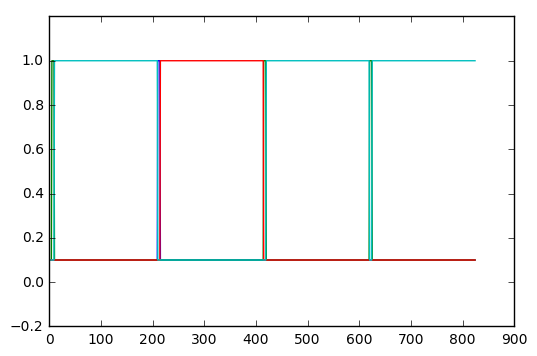

In [3]:
plt.plot(range(x.shape[1]), trial, range(x.shape[1]), target)
plt.ylim([-.2, 1.2])
plt.show()

# Add selective time masking, run the trial

In [4]:
t_connectivity = []

for i in range(x.shape[1]):
    if 4 <= i and i <= 3 or 34 <= i and i <= 33:
        t_connectivity.append(np.zeros_like(sim.W_rec))
    else:
        t_connectivity.append(np.ones_like(sim.W_rec))

In [5]:
outputs, states = sim.run_trial(trial, t_connectivity)

# Plot output of network

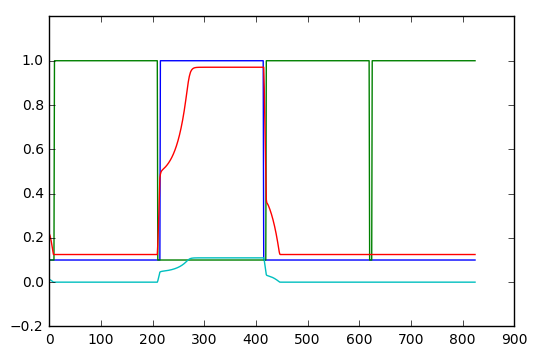

In [6]:
plt.plot(range(x.shape[1]), target, range(x.shape[1]), outputs[:, 0])
plt.ylim([-.2, 1.2])
plt.show()

# Plot states over time, without and with RELU

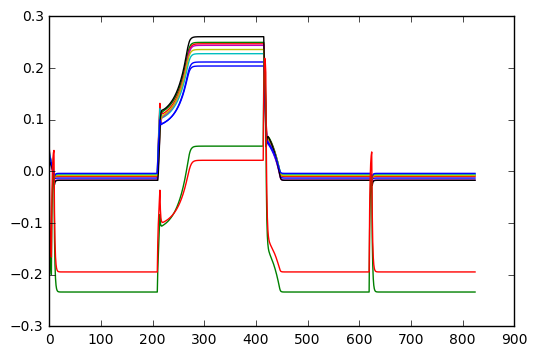

In [7]:
for i in range(states.shape[2]):
    plt.plot(range(states.shape[0]), states[:,0,i])
plt.show()

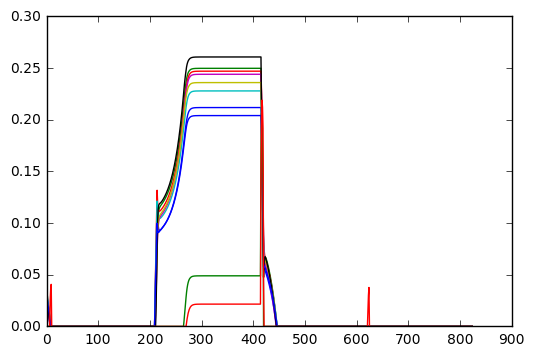

In [8]:
for i in range(states.shape[2]):
    plt.plot(range(states.shape[0]), np.maximum(states[:,0,i], np.zeros_like(states[:,0,i])))
plt.show()

# Plot W_rec and then animate effective W_rec given state and RELU

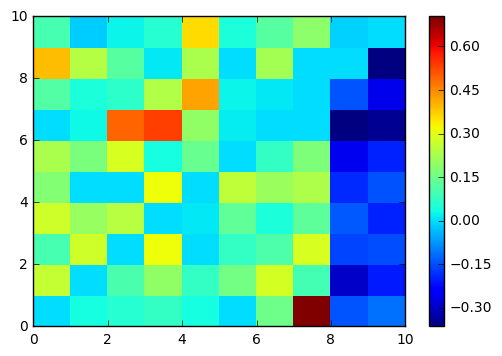

In [9]:
plt.pcolor(sim.W_rec)
plt.colorbar()
plt.show()

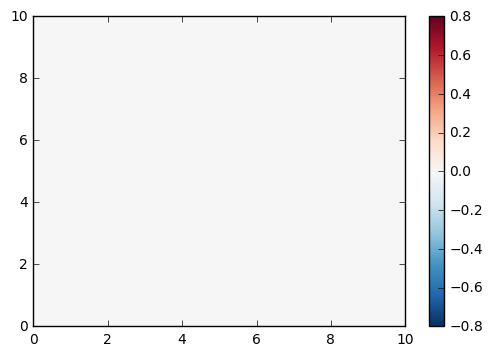

In [11]:
import matplotlib.animation as animation 
from IPython.display import HTML
from matplotlib import rc

fig = plt.figure()
    
ims = []


for i in range(states.shape[0]):
    Wi = np.matmul(np.absolute(sim.W_rec),sim.dale_rec) * t_connectivity[i]
    for j in range(sim.W_rec.shape[0]):
        if states[i, 0, j] < 0:
            Wi[:, j] = 0
    ims.append((plt.pcolor(Wi, vmin = -.8, vmax = .8, cmap='RdBu_r'),))

plt.colorbar()
rc('animation', html='html5')


animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=3000,
                                   blit=True)

In [12]:
Wi = np.matmul(np.absolute(sim.W_rec),sim.dale_rec) * t_connectivity[i]
for j in range(sim.W_rec.shape[0]):
    if states[300, 0, j] < 0:
        Wi[:, j] = 0
np.linalg.eigvals(Wi)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

# Effective input and output matrices

In [34]:
np.absolute(sim.W_in)

array([[  6.68583030e-04,   5.06563345e-04],
       [  6.20656239e-04,   6.78038166e-04],
       [  1.01809934e-01,   3.12404847e-03],
       [  6.97707874e-04,   7.49296800e-04],
       [  1.45299613e-01,   8.19125155e-04],
       [  4.34688963e-02,   1.63045770e-04],
       [  6.42660423e-04,   5.43547096e-04],
       [  3.04754532e-04,   4.82749252e-04],
       [  2.67800856e-02,   2.39649951e-01],
       [  4.83297631e-02,   1.58043101e-01]], dtype=float32)

In [35]:
np.matmul(np.absolute(sim.W_out),sim.dale_out)

array([[ 0.53144687,  0.42208976,  0.92217344,  0.54488546,  0.71177375,
         0.47384894,  0.56268251,  0.52166402,  0.        ,  0.        ],
       [ 0.08943545,  0.06126143,  0.06561668,  0.0482469 ,  0.04049642,
         0.03969736,  0.05950575,  0.02226794,  0.        ,  0.        ]])

# Hahnloser Fixed Point Strategy

In [21]:
permutations = np.array(list(itertools.product([0,1], repeat=10)))
input_vec = np.matmul(np.absolute(sim.W_in), np.array([.1,.1]))
identity = np.diag(np.ones(10))

count = 0
for p in permutations:
    #define active weight matrix
    Wp = np.matmul(np.absolute(sim.W_rec),sim.dale_rec)
    for i in p:
        if i == 0:
            Wp[:,i] = 0
    
    #check for fixed point
    I = np.matmul(np.linalg.inv(identity - Wp), input_vec)
    fixed = True
    for i in range(10):
        if p[i] == 0 and I[i] >= 0:
            fixed = False
        if p[i] == 1 and I[i] < 0:
            fixed = False
            
    if fixed == True:
        count += 1
        print p, I
        
print count

[0 0 0 0 0 0 0 0 1 1] [-0.01638054 -0.02412818 -0.01725194 -0.0143977  -0.02304959 -0.02276586
 -0.03210974 -0.01700048  0.00799868  0.02124759]
1


# "Black Box" paper analysis

In [36]:
def q(x):
    f = (1.0 / np.array(sim.tau)) * (-x + np.matmul(np.maximum(x, np.zeros_like(x)),
                                np.transpose(np.matmul(np.absolute(sim.W_rec),sim.dale_rec))))
    q = .5 * np.sum(np.square(f))
    return q

#+ np.matmul(rnn_in, np.transpose(np.absolute(sim.W_in))))
               
def dFidxj(x, i, j):
    if x[j] > 0:
        d = - 1.0 / sim.tau + (1.0 / sim.tau) * np.matmul(np.absolute(sim.W_rec),sim.dale_rec)[i][j]
    else:
        d = -1.0 / sim.tau
    return d
    
def grad_q(x):
    g = np.zeros_like(x)
    for j in range(len(x)):
        for i in range(len(x)):
            f = (1.0 / np.array(sim.tau)) * (-x + np.matmul(np.maximum(x, np.zeros_like(x)),
                                np.transpose(np.matmul(np.absolute(sim.W_rec),sim.dale_rec))))
            g[j] += dFidxj(x,i,j) * f[i]
    return g
        
                           
def hess_q(x):
    h = np.zeros((len(x), len(x)))
    for i in range(len(x)):
        for j in range(len(x)):
            for k in range(len(x)):
                h[i,j] += dFidxj(x,k,i) * dFidxj(x,k,j)
    return h

In [37]:
from scipy.optimize import minimize

def opt(init):
    res = minimize(q, init, method = 'Newton-CG', jac = grad_q, hess = hess_q,
               tol = 1e-10, options = {'disp':True})
    
    if not res.success:
        print "FAILED TO CONVERGE"
    return res.x

### optimize q given some state as initial condition

In [38]:
trial = x[4]
outputs, states = sim.run_trial(trial)

In [39]:
test = opt(states[375,0,:])

         Current function value: 0.000024
         Iterations: 7
         Function evaluations: 36
         Gradient evaluations: 31
         Hessian evaluations: 8
FAILED TO CONVERGE


In [40]:
test

array([ 0.01214963,  0.01580648,  0.01227004,  0.02201905,  0.00501246,
        0.0045881 , -0.00188546, -0.0006784 ,  0.02466276, -0.13475508])

### linear stability by taking eigenvalues of jacobian

In [41]:
def eig_dF(x):
    J = np.zeros((len(x), len(x)))
    for i in range(len(x)):
        for j in range(len(x)):
            J[i,j] = dFidxj(x,i,j)
    return np.linalg.eigvals(J)

In [42]:
eig_dF(test)

array([ -4.65676339e-01+0.j        ,   2.11759627e-02+0.j        ,
         3.69268276e-03+0.00785853j,   3.69268276e-03-0.00785853j,
        -1.83589366e-02+0.00609231j,  -1.83589366e-02-0.00609231j,
        -8.38218601e-03+0.j        ,  -1.77849300e-02+0.j        ,
        -2.26784226e-18+0.j        ,   5.75370636e-18+0.j        ])

In [43]:
np.linalg.eigvals(sim.W_rec)

array([ 0.82125401+0.34966224j,  0.82125401-0.34966224j,
       -0.10465679+0.27348879j, -0.10465679-0.27348879j,
       -0.41435337+0.16886108j, -0.41435337-0.16886108j,
       -0.36297476+0.j        , -0.27555618+0.j        ,
        0.01702161+0.06658514j,  0.01702161-0.06658514j], dtype=complex64)

### visualization of network with zero input, from initial conditions

In [44]:
tester = Simulator(params, weights_path="./tasks/weights/flipflop.npz")
tester.init_state = states[175,0,:]

zero_trial = .1 * np.zeros_like(trial)

var_trial = .01 * np.random.normal(trial.shape) 

outputs, states = sim.run_trial(zero_trial, use_input=True)

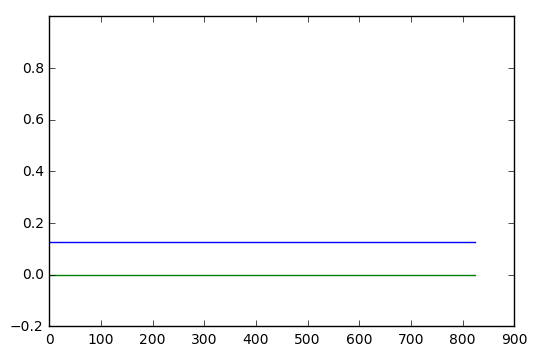

In [45]:
plt.plot(range(x.shape[1]), outputs[:,0])
plt.ylim([-.2, 1])
plt.show()

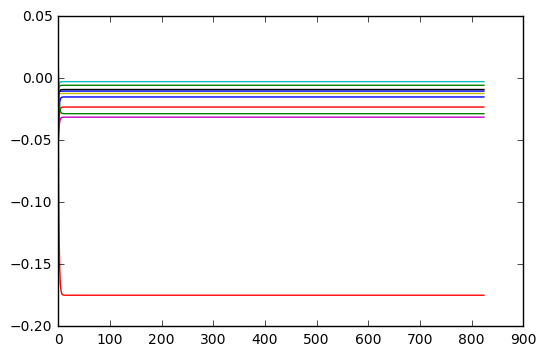

In [46]:
for i in range(states.shape[2]):
    plt.plot(range(states.shape[0]), states[:,0,i])
plt.show()

In [287]:
states[40]

array([[ 0.08076096,  0.14340211,  0.1437528 ,  0.12672167,  0.1284159 ,
         0.21113014,  0.17864681,  0.15997086,  0.16525014,  0.24387161]])

In [273]:
out_state = states[40,0]